# Envs

In [1]:
"""
   Redo from DWF Python Example - Analog_Transistor.py
   Author:  Tran Le Phuong Lan
   Date:  2025-05-21

   Requires:                       
       Python 2.7, 3
"""

from ctypes import *

import math
import time
import sys
import os
from os import sep                # OS specific file path separators
import matplotlib.pyplot as plt
import numpy

os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"

if sys.platform.startswith("win"):
    dwf = cdll.dwf
    constants_path = "C:" + sep + "Program Files (x86)" + sep + "Digilent" + sep + "WaveFormsSDK" + sep + "samples" + sep + "py"
elif sys.platform.startswith("darwin"): # on macOS
    dwf = cdll.LoadLibrary("/Library/Frameworks/dwf.framework/dwf")
else: # on Linux
    dwf = cdll.LoadLibrary("libdwf.so")
    constants_path = sep + "usr" + sep + "share" + sep + "digilent" + sep + "waveforms" + sep + "samples" + sep + "py"

# Import constans
sys.path.append(constants_path)
import dwfconstants as constants

# Open the AD3

In [2]:
version = create_string_buffer(16)
dwf.FDwfGetVersion(version)
print("Version: "+str(version.value))

cdevices = c_int()
dwf.FDwfEnum(0, byref(cdevices))
print("Number of Devices: "+str(cdevices.value))

if cdevices.value == 0:
    print("no device detected")
    quit()

dwf.FDwfParamSet(constants.DwfParamOnClose, 0) # 0 = run, 1 = stop, 2 = shutdown

print("Opening first device")
hdwf = c_int()

# ChatGPT:
# byref() is a function from the ctypes module in Python, 
# which is used to pass a reference to a variable rather than its value
dwf.FDwfDeviceOpen(-1, byref(hdwf))

if hdwf.value == constants.hdwfNone.value:
    print("failed to open device")
    quit()

Version: b'3.24.2'
Number of Devices: 1
Opening first device


In [3]:
dwf.FDwfDeviceAutoConfigureSet(hdwf, 0) # 0 = the device will only be configured when FDwf###Configure is called

1

# Physical setup

## EXP1


Comprises of

- 1. W1 - (Terminal 1 of R1 AND 1+) - R1 - (Terminal 2 of R1 AND 1-)- W2

- 2. Note: W1 and W2 already shares the internal ground.

# App

## EXP 1

- recording is used with shift-scan mode

In [4]:
import threading
import time
import logging

format = "%(asctime)s: %(message)s"
logging.basicConfig(format=format, level=logging.INFO,
                        datefmt="%H:%M:%S")

In [5]:
out_ch_1 = c_int(0)
out_ch_2 = c_int(1)

logging.info(f"configure wave gen 1")

dwf.FDwfAnalogOutNodeEnableSet(hdwf, out_ch_1, c_int(0), c_int(1))
dwf.FDwfAnalogOutNodeFunctionSet(hdwf, out_ch_1, c_int(0), constants.funcSquare)
dwf.FDwfAnalogOutNodeFrequencySet(hdwf, out_ch_1, c_int(0), c_double(1))

# int FDwfAnalogOutRunSet(HDWF hdwf, int idxChannel, double secRun);
dwf.FDwfAnalogOutRunSet(hdwf, out_ch_1, c_double(5))

# FDwfAnalogOutRepeatSet(HDWF hdwf, int idxChannel, int cRepeat);
dwf.FDwfAnalogOutRepeatSet(hdwf, out_ch_1, c_int(1))

# dwf.FDwfAnalogOutNodeAmplitudeSet(hdwf, out_ch, c_int(0), c_double(2))
dwf.FDwfAnalogOutNodeAmplitudeSet(hdwf, out_ch_1, c_int(0), c_double(1))

# FDwfAnalogOutOffsetSet(HDWF hdwf, int idxChannel, double vOffset)
dwf.FDwfAnalogOutOffsetSet(hdwf, out_ch_1, c_double(1))

# set the idle state
# FDwfAnalogOutIdleSet(HDWF hdwf, int idxChannel, DwfAnalogOutIdle idle);
idle = constants.DwfAnalogOutIdleOffset # c_int(1)
dwf.FDwfAnalogOutIdleSet(hdwf, out_ch_1, idle)

dwf.FDwfAnalogOutConfigure(hdwf, out_ch_1, c_int(3))

17:45:50: configure wave gen 1


1

In [6]:
# dwf.FDwfAnalogOutConfigure(hdwf, out_ch_1, c_int(0))

In [7]:
out_ch_2 = c_int(1)

logging.info(f"configure wave gen 2")

dwf.FDwfAnalogOutNodeEnableSet(hdwf, out_ch_2, c_int(0), c_int(1))
dwf.FDwfAnalogOutNodeFunctionSet(hdwf, out_ch_2, c_int(0), constants.funcSquare)
dwf.FDwfAnalogOutNodeFrequencySet(hdwf, out_ch_2, c_int(0), c_double(1))

# int FDwfAnalogOutRunSet(HDWF hdwf, int idxChannel, double secRun);
dwf.FDwfAnalogOutRunSet(hdwf, out_ch_2, c_double(5))

# FDwfAnalogOutRepeatSet(HDWF hdwf, int idxChannel, int cRepeat);
dwf.FDwfAnalogOutRepeatSet(hdwf, out_ch_2, c_int(1))

# dwf.FDwfAnalogOutNodeAmplitudeSet(hdwf, out_ch, c_int(0), c_double(2))
dwf.FDwfAnalogOutNodeAmplitudeSet(hdwf, out_ch_2, c_int(0), c_double(1))

# FDwfAnalogOutOffsetSet(HDWF hdwf, int idxChannel, double vOffset)
dwf.FDwfAnalogOutOffsetSet(hdwf, out_ch_2, c_double(2))

# set the idle state
# FDwfAnalogOutIdleSet(HDWF hdwf, int idxChannel, DwfAnalogOutIdle idle);
idle = constants.DwfAnalogOutIdleOffset # c_int(1)
dwf.FDwfAnalogOutIdleSet(hdwf, out_ch_2, idle)

# Apply the configuration
dwf.FDwfAnalogOutConfigure(hdwf, out_ch_2, c_int(3))

17:45:53: configure wave gen 2


1

In [8]:
# dwf.FDwfAnalogOutConfigure(hdwf, out_ch_2, c_int(0))

In [9]:
import json
restart_record = True

if restart_record == True:
    f = open("../data/output.jsonl", 'w')
else:
    f = open("../data/output.jsonl", 'a')

In [10]:
def record_function(hdwf, osc_ch, hzAcq, nSamples, stop):

    rgdSamples = (c_double*nSamples)()
    sts = c_byte()
    cValid = c_int()

    #set up acquisition
    dwf.FDwfAnalogInChannelEnableSet(hdwf, osc_ch, c_int(1))
    dwf.FDwfAnalogInChannelRangeSet(hdwf, osc_ch, c_double(10))
    dwf.FDwfAnalogInAcquisitionModeSet(hdwf, c_int(1)) #acqmodeScanShift
    dwf.FDwfAnalogInFrequencySet(hdwf, hzAcq)
    dwf.FDwfAnalogInBufferSizeSet(hdwf, c_int(nSamples))
    # allow configure, and stop the channel
    dwf.FDwfAnalogInConfigure(hdwf, c_int(1), c_int(0)) 

    #wait at least 2 seconds for the offset to stabilize
    time.sleep(2)

    #begin acquisition
    # DO NOT allow configure, and run the channel
    dwf.FDwfAnalogInConfigure(hdwf, c_int(0), c_int(1)) 

    idx = 0
    logging.info("starting record process")
   
    while True: #time.time()-start < 10:
        logging.info("In the record loop")
        dwf.FDwfAnalogInStatus(hdwf, c_int(1), byref(sts))
        

        dwf.FDwfAnalogInStatusSamplesValid(hdwf, byref(cValid))

        dwf.FDwfAnalogInStatusData(hdwf, osc_ch, byref(rgdSamples), cValid) # get channel 1 data
        #dwf.FDwfAnalogInStatusData(hdwf, c_int(1), byref(rgdSamples), cValid) # get channel 2 data
        logging.info(f"{sts=}")
        logging.info(f"{cValid.value=}")
        logging.info(f"{rgdSamples[0:10]}")
        
        # write to a file
        json_obj = {"id": idx, "value": list(rgdSamples)}
        f.write(json.dumps(json_obj) + '\n')

        time.sleep(0.1)

        if stop():
            # allow reconfigure, and stop the channel
            dwf.FDwfAnalogInConfigure(hdwf, c_int(1), c_int(0))
            f.close()
            break
        

In [ ]:
sts = c_byte()
hzAcq = c_double(200)
nSamples = 1000
osc_ch = c_int(0)

logging.info("Main    : before starting recording")
stop_threads = False
x = threading.Thread(target=record_function, args=(hdwf, osc_ch, hzAcq, nSamples, lambda: stop_threads,))
logging.info("Main    : before running recording")
x.start()
logging.info("Main    : change configuration of wavegenerator")
# x.join()
logging.info("Main    : all done")

17:46:07: Main    : before starting recording
17:46:07: Main    : before running recording
17:46:07: Main    : change configuration of wavegenerator
17:46:07: Main    : all done


17:46:09: starting record process
17:46:09: In the record loop
17:46:10: sts=c_byte(3)
17:46:10: cValid.value=0
17:46:10: [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
17:46:10: In the record loop
17:46:10: sts=c_byte(3)
17:46:10: cValid.value=21
17:46:10: [0.9942674615062551, 0.9942674615062551, 0.9942674615062551, 0.9942674615062551, 0.9942674615062551, 0.9951680699690628, 0.9951680699690628, 0.9951680699690628, 0.9951680699690628, 0.9951680699690628]
17:46:10: In the record loop
17:46:10: sts=c_byte(3)
17:46:10: cValid.value=42
17:46:10: [0.9942674615062551, 0.9942674615062551, 0.9942674615062551, 0.9942674615062551, 0.9942674615062551, 0.9951680699690628, 0.9951680699690628, 0.9951680699690628, 0.9951680699690628, 0.9951680699690628]
17:46:10: In the record loop
17:46:10: sts=c_byte(3)
17:46:10: cValid.value=64
17:46:10: [0.9942674615062551, 0.9942674615062551, 0.9942674615062551, 0.9942674615062551, 0.9942674615062551, 0.9951680699690628, 0.9951680699690628, 0.995168069969062

In [19]:
stop_threads = True

In [ ]:
# reconfigure the generator

# FDwfAnalogOutOffsetSet(HDWF hdwf, int idxChannel, double vOffset)
# dwf.FDwfAnalogOutOffsetSet(hdwf, out_ch, c_double(0))
# dwf.FDwfAnalogOutNodeFunctionSet(hdwf, c_int(0), c_int(0), c_ubyte(2)) # funcSquare   = c_ubyte(2)
# dwf.FDwfAnalogOutConfigure(hdwf, c_int(0), c_int(3))

In [15]:
# Start the generator
logging.info("wavegen ch 1 ON, while wavegen ch 2 OFF")
dwf.FDwfAnalogOutConfigure(hdwf, out_ch_1, c_int(1))
# dwf.FDwfAnalogOutConfigure(hdwf, out_ch_2, c_int(0))

17:46:29: wavegen ch 1 ON, while wavegen ch 2 OFF


1

In [18]:
# FDwfAnalogOutStatus(HDWF hdwf, int idxChannel, DwfState *psts)
sts = c_ubyte()
dwf.FDwfAnalogOutStatus(hdwf, out_ch_1, byref(sts))
logging.info(f"status of out ch 1: {sts}")

dwf.FDwfAnalogOutStatus(hdwf, out_ch_2, byref(sts))
logging.info(f"status of out ch 2: {sts}")

17:46:36: status of out ch 1: c_ubyte(2)
17:46:36: status of out ch 2: c_ubyte(0)


In [116]:
# Start the generator
logging.info("wavegen ch 1 OFF, while wavegen ch 2 ON")
# dwf.FDwfAnalogOutConfigure(hdwf, out_ch_1, c_int(0))
dwf.FDwfAnalogOutConfigure(hdwf, out_ch_2, c_int(1))

18:28:08: wavegen ch 1 OFF, while wavegen ch 2 ON


1

In [119]:
# FDwfAnalogOutStatus(HDWF hdwf, int idxChannel, DwfState *psts)
sts = c_ubyte()
dwf.FDwfAnalogOutStatus(hdwf, out_ch_1, byref(sts))
logging.info(f"status of out ch 1: {sts}")

dwf.FDwfAnalogOutStatus(hdwf, out_ch_2, byref(sts))
logging.info(f"status of out ch 2: {sts}")

18:28:15: status of out ch 1: c_ubyte(2)
18:28:15: status of out ch 2: c_ubyte(2)


In [120]:
# Start the generator both
logging.info("Both ON")
# dwf.FDwfAnalogOutConfigure(hdwf, out_ch_1, c_int(1))
# dwf.FDwfAnalogOutConfigure(hdwf, out_ch_2, c_int(1))
dwf.FDwfAnalogOutConfigure(hdwf, -1, c_int(1))

18:28:19: Both ON


1

In [122]:
# FDwfAnalogOutStatus(HDWF hdwf, int idxChannel, DwfState *psts)
sts = c_ubyte()
dwf.FDwfAnalogOutStatus(hdwf, out_ch_1, byref(sts))
logging.info(f"status of out ch 1: {sts}")

dwf.FDwfAnalogOutStatus(hdwf, out_ch_2, byref(sts))
logging.info(f"status of out ch 2: {sts}")

18:28:25: status of out ch 1: c_ubyte(2)
18:28:25: status of out ch 2: c_ubyte(2)


In [74]:
# FDwfAnalogOutStatus(HDWF hdwf, int idxChannel, DwfState *psts)
sts = c_ubyte()
dwf.FDwfAnalogOutStatus(hdwf, out_ch_1, byref(sts))
logging.info(f"status of out ch 1: {sts}")

dwf.FDwfAnalogOutStatus(hdwf, out_ch_2, byref(sts))
logging.info(f"status of out ch 2: {sts}")

18:18:03: status of out ch 1: c_ubyte(2)
18:18:03: status of out ch 2: c_ubyte(2)


In [46]:
# Stop the generator
logging.info("stop all wavegen chs")
dwf.FDwfAnalogOutConfigure(hdwf, -1, c_int(0))

18:07:09: stop all wavegen chs


1

# Close AD3

In [20]:
dwf.FDwfDeviceCloseAll()

1

# Plot the recording of shift-scan mode (must use animation)

In [21]:
import json
# Path to your .jsonl file
jsonl_path = "../data/output.jsonl"
# index = count()
with open(jsonl_path, 'r') as f:
    lines = f.readlines()
# convert lines to appropriate data
data = []
for idx, elem in enumerate(lines):
    json_elem = json.loads(elem)
    data.append(json_elem)

17:47:02: Animation.save using <class 'matplotlib.animation.HTMLWriter'>


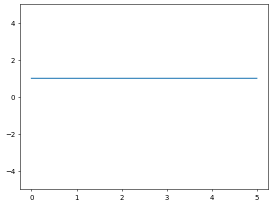

In [22]:
%matplotlib inline

import numpy as np
import matplotlib.animation
import matplotlib.pyplot as plt
import numpy as np
import json
from itertools import count


plt.rcParams["animation.html"] = "jshtml"
plt.rcParams['figure.dpi'] = 50

fig, ax = plt.subplots()

# ax.set_ylim((-5, 5))
  # Clear the subplot conte
ax.cla()

x_value = []
y_value = []

# Path to your .jsonl file
jsonl_path = "../data/output.jsonl"

with open(jsonl_path, 'r') as f:
    lines = f.readlines()
# convert lines to appropriate data
data = []
for idx, elem in enumerate(lines):
    json_elem = json.loads(elem)
    data.append(json_elem)

index = count()

def animate(t):

    idx_cn = next(index)
    # print(f"{idx_cn=}")

    if idx_cn < len(data):
        x_axis = np.arange(0, len(data[idx_cn]['value']), 1) / 200
        y_axis = data[idx_cn]['value']
        
        # Clear the subplot content
        ax.cla() 

        # ax.set_xlim([-5, 5])
        ax.set_ylim([-5, 5])
    
        ax.plot(x_axis, y_axis)
   

# frames = number of total pictures
# interval = time between two adjacent frame
matplotlib.animation.FuncAnimation(fig, animate, frames=len(data), interval = 1)

# Multithread exp

- EXP 1

  - thread 1: write to file

  - thread 2: read from file to plot

- NOTE: why trying to solve the problem of plot animation in jupyternotebook, while the main focus is we could do a python code to make all types of interactions? because the main focus is the measurement, not coding

In [28]:
import threading
import time
import logging

format = "%(asctime)s: %(message)s"
logging.basicConfig(format=format, level=logging.INFO,
                        datefmt="%H:%M:%S")

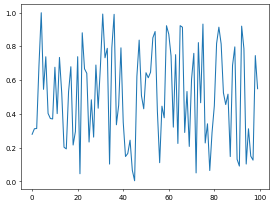

In [ ]:
import numpy as np
import time
import os 


def write_to_file (file_path, num_samples, stop):
    
    global wrtie_idx

    with open(file_path, 'w') as f:
        while True:
            # generate a random array
            y_axis = np.random.rand(num_samples)
            
            # write to a file
            json_obj = {"id": int(wrtie_idx), "value": list(y_axis)}
            f.write(json.dumps(json_obj) + '\n')

            # increase idx
            wrtie_idx = wrtie_idx + 1

            if stop():
                break 

            time.sleep(0.5)

def read_from_file_and_plot (file_path, num_samples, stop):
    global read_idx, wrtie_idx
    
    # read an object from .jsonl
    while True:
        
        logging.info(f"current {read_idx=}")
        logging.info(f"current {wrtie_idx=}")

        # check if the file is empty
        if os.stat(file_path).st_size == 0: 
            pass
        else:
            # open the file
            with open(file_path, 'r') as f:
                if read_idx > wrtie_idx :
                    pass
                else:
                    for line in f:
                        data = json.loads(line)
                        if data['id'] == read_idx:
                            break
                    
                    # plot
                    logging.info(f"read-in: {data=}")
                    # CAN NOT PLOT FROM THREAD
                    # y_axis = data['value']
                    # x_axis = np.arange(len(y_axis))
                    # clear figure
                    # plt.clf()
                    # plt.plot(x_axis, y_axis)
                    

                    # increase
                    read_idx = read_idx + 1
                    
        # exit
        if stop():
            break

        time.sleep(1)


In [58]:
num_samples = 100
wrtie_idx = 0 # = instant report of total lines in .jsonl file
read_idx = 0

file_path = "C:/Users/20245580/LabCode/AD3/data/output_exp1.jsonl"

logging.info("Main   : before starting recording")
stop_write_threads = False
stop_read_threads = False
thread_write = threading.Thread(target=write_to_file, args=(file_path,num_samples, lambda: stop_write_threads,))
# thread_read = threading.Thread(target=read_from_file_and_plot, args=(file_path,num_samples, lambda: stop_read_threads,))


logging.info("Main    : running writing thread")
thread_write.start()
logging.info("Main    : all done")

19:03:15: Main   : before starting recording
19:03:15: Main    : running writing thread
19:03:15: Main    : all done


In [ ]:
# logging.info("Main    : running reading thread")
# thread_read.start()


In [61]:
stop_write_threads = True
stop_read_threads = True

In [ ]:
# reference: https://www.timsanteford.com/posts/how-to-read-and-parse-jsonl-files-in-python/
# Open the file and process line by line
import os 

file_path = "C:/Users/20245580/LabCode/AD3/data/output_exp1.jsonl"

# chatGPT
## WORK
if os.stat(file_path).st_size == 0:
    print("File is empty.")
else:
    print("File is not empty.")


with open(file_path, 'r', encoding='utf-8') as file:
    # print(len(file))

    ## COMMENT NOT WORKING
    # if file.readline == '': # check the file is empty (chatGPT)
    #     print(f"empty file")

    for line in file:
        # Parse each line as JSON
        try:
            data = json.loads(line)
            # print(data['id']==0)  # Here you can handle the data as needed
            print(data == None)
        except json.JSONDecodeError as e:
            print(f"Error parsing line: {line}")
            print(e)

File is empty.
